### Data setup and Multivariate Linear Regression - Marieth

In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from numpy.linalg import inv
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import copy

C:\Users\schoo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\schoo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


<div class="alert alert-block alert-success">

### Basic Exploration

In [2]:
df_nas = pd.read_excel('Training Data.xlsx')

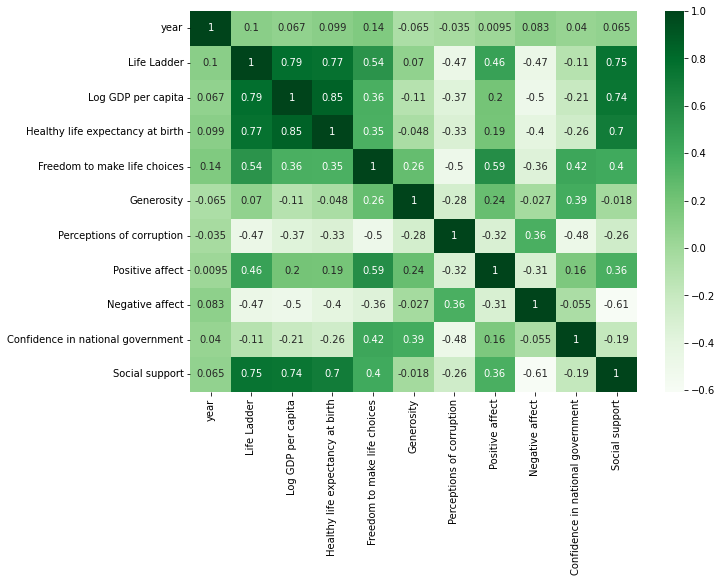

In [3]:
df = df_nas.dropna() ### Hopefully won't be needed if Matthew's idea works but we can keep it in anyway

plt.figure(figsize=(10, 7))

dataplot = sb.heatmap(df.corr(), cmap="Greens", annot=True)

plt.show()

<div class="alert alert-block alert-success">

### Convert data into right shape

In [4]:
# Take out the columns we need 

X_train_pre = df[['Log GDP per capita','Healthy life expectancy at birth', 'Freedom to make life choices',
              'Generosity', 'Perceptions of corruption', 'Life Ladder', 'Positive affect','Negative affect',
             'Confidence in national government']]

y_train_pre = df[['Social support']]


In [5]:
X_train= X_train_pre.to_numpy()
X_train.shape

(720, 9)

In [6]:
y_train= y_train_pre.to_numpy()
y_train.shape

(720, 1)

<div class="alert alert-block alert-success">

### Find the best coefficients and predict 

Remember the least squares solution is:
$$x^* = (A^TA)^{-1}A^Tb$$

In [7]:
def find_optz_w(A,y): 
    
    ''' 
    A: Takes a matrix with our predictors 
    y: Takes in a vector with our traning target variables
    '''
    
    (n, predictors) = A.shape 
    p = predictors + 1
    
    new_A = np.ones(shape=(n,p)) # Will leave our first column with 1s for when we multiply by the first coefficients 
    new_A[:,1:]=A
                
    w = np.linalg.inv(new_A.T @ new_A) @ new_A.T @ y #minimizes_mean_squared_error from homework 1 
    return w


In [8]:
optz_w = find_optz_w(X_train,y_train)
optz_w

array([[ 0.18521929],
       [ 0.02353781],
       [ 0.00256426],
       [-0.00395562],
       [ 0.0122431 ],
       [ 0.1144781 ],
       [ 0.0403437 ],
       [ 0.1018497 ],
       [-0.42893811],
       [-0.00947399]])

In [9]:
def get_targets(optz_w, A):
    
    '''
    optz_w: Takes in our array of optz_w (our coefficients) 
    A: Takes a matrix with our predictors 
    '''
    
    (n, predictors) = A.shape # P is the number of predictors we have 
    p = predictors + 1
    
    new_A = np.ones(shape=(n,p)) # Will leave our first column with 1s for when we multiply by the first coefficients 
    new_A[:,1:]=A
        
    targets = np.dot(new_A, optz_w)
    
    return targets


In [10]:
# We convert our optimized w's into a numpy array. This is our model 
model = np.array(optz_w) 

In [11]:
# Run the model on our training data
predicted_target = get_targets(model, X_train)

# Output  mse:
mse = mean_squared_error(y_train,predicted_target) 
print("mse:", mse)

mse: 0.004247051562830176


In [12]:
predicted_target.shape

(720, 1)

<font color='red'>IMPORTANT NOTE:</font> I just used a function to calculate mse here so that you can make a function for it


<div class="alert alert-block alert-success">

### Find optz_w using a function

In [13]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

X_train = sm.add_constant(X_train)

print('Intercept:', regr.intercept_)
print('Coefficients:', regr.coef_)

model_function = sm.OLS(y_train, X_train).fit()
predictions = model_function.predict(X_train)

mse = mean_squared_error(y_train,predictions) 
print(" ")
print("mse:", mse)

Intercept: [0.18521929]
Coefficients: [[ 0.02353781  0.00256426 -0.00395562  0.0122431   0.1144781   0.0403437
   0.1018497  -0.42893811 -0.00947399]]
 
mse: 0.004247051562830176


<div class="alert alert-block alert-success">

### Compare "scratch" function vs the official function on the training data set

Note: Scratch function is the one we come up with

In [14]:
# First convert to the right data type and shape 

scratch_coeff = optz_w.reshape(10,)
print(scratch_coeff.shape)

func_coeff = (regr.coef_.T).reshape(9,)
print(func_coeff.shape)

(10,)
(9,)


In [15]:
arr_coeff = np.array([scratch_coeff,func_coeff])
print(arr_coeff)

names_coeff = ["Scratch coefficients", "Function coefficients"]

compare_coef = pd.DataFrame(arr_coeff, names_coeff)
compare_coef

[array([ 0.18521929,  0.02353781,  0.00256426, -0.00395562,  0.0122431 ,
         0.1144781 ,  0.0403437 ,  0.1018497 , -0.42893811, -0.00947399])
 array([ 0.02353781,  0.00256426, -0.00395562,  0.0122431 ,  0.1144781 ,
         0.0403437 ,  0.1018497 , -0.42893811, -0.00947399])            ]


C:\Users\schoo\AppData\Local\Temp/ipykernel_2504/3082514591.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_coeff = np.array([scratch_coeff,func_coeff])


,0
Scratch coefficients,"[0.1852192904702417, 0.0235378126950402, 0.002..."
Function coefficients,"[0.023537812695052205, 0.0025642612701424726, ..."


In [16]:
arr_mse = np.array([0.004247051562830176,0.004247051562830176])
names_mse = ["Scratch", "Function"]

compare_mse = pd.DataFrame(arr_mse, names_mse, columns=["mse"])
compare_mse

,mse
Scratch,0.004247
Function,0.004247


<div class="alert alert-block alert-success">

### Use our "scratch" function on the testing data set

In [17]:
df_test_nas = pd.read_excel('Testing Data 2021.xlsx')

df_test = df_test_nas.dropna() 

len(df_test)

100

In [18]:
X_test_pre = df_test[['Log GDP per capita','Healthy life expectancy at birth', 'Freedom to make life choices',
              'Generosity', 'Perceptions of corruption', 'Life Ladder', 'Positive affect','Negative affect',
             'Confidence in national government']]

y_test_pre = df_test[['Social support']]

In [19]:
X_test= X_test_pre.to_numpy()
X_test.shape

(100, 9)

In [20]:
y_test= y_test_pre.to_numpy()
y_test.shape

(100, 1)

Note to self: Don't send to find_opz_w, use the optimized model we previously found

In [21]:
# Run the model on our testing data
predicted_target_test = get_targets(model, X_test)

In [22]:
mse_test = mean_squared_error(y_test,predicted_target_test) 
print("mse:", mse_test)

mse: 0.0029650796848547235


<div class="alert alert-block alert-success">

Very close to our training data set! 

[Text(0.5, 1.0, 'Log GDP vs Social Support')]

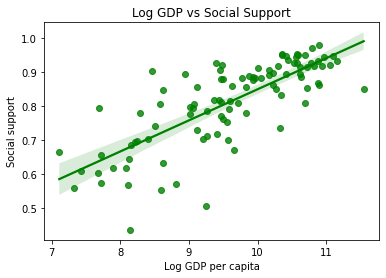

In [38]:
sb.regplot(x="Log GDP per capita",
            y="Social support", color = "green", 
            data=df_test).set(title = "Log GDP vs Social Support")

[Text(0.5, 1.0, 'Life Ladder vs Social Support')]

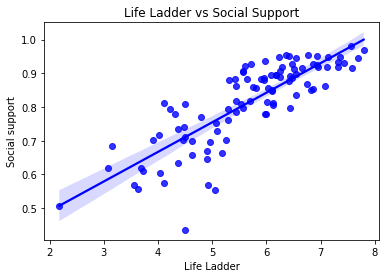

In [39]:
sb.regplot(x="Life Ladder",
            y="Social support", color = "blue", 
            data=df_test).set(title = "Life Ladder vs Social Support")


[Text(0.5, 1.0, 'Healthy life expectancy at birth vs Social Support')]

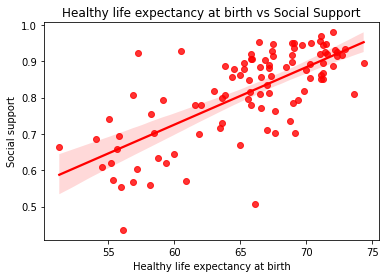

In [43]:
sb.regplot(x="Healthy life expectancy at birth",
            y="Social support", color = "red", 
            data=df_test).set(title = "Healthy life expectancy at birth vs Social Support")


### MSE algorithm and PCA - Nicole

In [23]:
# Define MSE Algorithm
# Find training MSE and testing MSE, and then compare with the built-in sklearn function MSE to see how similar they are
def mse_algorithm(X, y, model):
    '''
    inputs:
        X: training/testing data set
        y: training/testing output
        model: our approximation of y based on our model
    output: the mean squared error
    '''
    N = X.shape[0] # number of data points
    predicted_target_test = get_targets(model, X)
    error = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        error[i] = (y[i] - predicted_target_test[i])**2
    avg_error = sum(error)/y.shape[0]
    return avg_error

In [24]:
X_train= X_train_pre.to_numpy()
X_test=X_test_pre.to_numpy()

In [25]:
# MSE for training dataset
mse_training = mse_algorithm(X_train, y_train, model)
mse_training

0.004247051562830175

In [26]:
# MSE for testing dataset
mse_testing = mse_algorithm(X_test, y_test, model)
mse_testing

0.0029650796848547235

The mean squared errors for the training and testing data sets are very similar, indicating that our multivariate linear model is a good fit for the data.

In [27]:
# Compare our MSE with the built-in MSE function in sklearn
function_model = sm.OLS(y_train, X_train).fit()
predictions_model = function_model.predict(X_train) 

mse = mean_squared_error(y_train,predictions_model) 
print(" ")
print("mse:", mse)

 
mse: 0.004323517046022029


The MSE for our training set, testing set, and the MSE from the built-in sklearn model are very similar, indicating again that our multivariate linear model is a good fit for the data.

Although our MSE is very small, we can perform principal component analysis to see if there are any features that describe a larger amount of our data than others. If so, we can reduce the dimension of our data to only include the features that describe most of the variance of our data.

In [34]:
# PCA done by hand

In [35]:
my_X_train_pre = copy.deepcopy(X_train_pre)

In [36]:
# First, we standardize the features 
min_val = np.min(my_X_train_pre)
max_val = np.max(my_X_train_pre)
for i in range(X_train_pre.shape[0]):
    for k in range(X_train_pre.shape[1]):
        my_X_train_pre.iloc[i,k] = (my_X_train_pre.iloc[i, k] - min_val[k])/(max_val[k] - min_val[k])

C:\Users\schoo\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:85: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\schoo\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:85: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [37]:
# Successfully standardized the data
my_X_train_pre.head()

,Log GDP per capita,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Life Ladder,Positive affect,Negative affect,Confidence in national government
0,0.343332,0.323690,0.125268,0.406953,0.903657,0.291565,0.319149,0.475519,0.197886
1,0.628068,0.836591,0.587278,0.246723,0.908163,0.404689,0.471337,0.498007,0.467525
2,0.742184,0.770915,0.847494,0.154720,0.871416,0.783793,0.799064,0.407108,0.326580
3,0.620243,0.742768,0.363076,0.127569,0.926239,0.357841,0.380681,0.674518,0.099812
4,0.854072,0.886630,0.907125,0.643828,0.335342,0.894766,0.767221,0.214067,0.436426


In [38]:
# Center the data
mean = np.mean(my_X_train_pre,axis = 0)
X_train_tilde = my_X_train_pre - mean
X_train_tilde.head()

,Log GDP per capita,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Life Ladder,Positive affect,Negative affect,Confidence in national government
0,-0.289720,-0.354344,-0.571968,0.086128,0.159737,-0.278987,-0.292323,0.100798,-0.256235
1,-0.004984,0.158557,-0.109958,-0.074102,0.164243,-0.165863,-0.140135,0.123286,0.013404
2,0.109132,0.092881,0.150258,-0.166105,0.127496,0.213241,0.187592,0.032387,-0.127541
3,-0.012809,0.064734,-0.334160,-0.193256,0.182319,-0.212711,-0.230792,0.299796,-0.354309
4,0.221020,0.208596,0.209890,0.323003,-0.408577,0.324214,0.155749,-0.160655,-0.017695


In [39]:
# Singular Value Decomposition to extract the singular values
U,S,VT = np.linalg.svd(X_train_tilde, full_matrices=False)

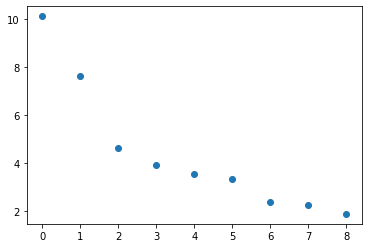

In [40]:
plt.plot(S, 'o')

We use the elbow method and see that there is a drop-off in variance explained by our data after the first three principal components.

In [41]:
variance = ((S[0]**2)+(S[1]**2)+(S[2]**2))/np.sum(S**2)
variance

0.7745744342325002

Our first three principal components explain over 77% of the variance of the data, meaning that if we reduce the dimension of our data to the first three principal components, we will still retain 77% of the variance in the original data.

In [42]:
# Training dataset
# Healthy life expectancy, Log GDP per capita, and life ladder have the most variance
variances_train = np.sort(np.var(X_train_pre))[::-3] 

In [43]:
cov_matrix = np.cov(X_train_pre)
cov_matrix.shape

(720, 720)

In [44]:
eigenvalues = np.linalg.eig(cov_matrix)[0]
eigenvectors = np.linalg.eig(cov_matrix)[1]

In [45]:
X_train_transformed = np.zeros(shape=(X_train_pre.shape[0],3))
X_train_transformed.shape

(720, 3)

In [46]:
X_train_transformed = eigenvectors[:,0:3]
X_train_transformed

array([[-0.03052054+0.j,  0.02742673+0.j,  0.01181399+0.j],
       [-0.04008296+0.j,  0.06591304+0.j, -0.00531988+0.j],
       [-0.03876952+0.j, -0.03794414+0.j, -0.01103202+0.j],
       ...,
       [-0.03762397+0.j,  0.00682379+0.j, -0.05297204+0.j],
       [-0.03172461+0.j,  0.00331688+0.j, -0.00361282+0.j],
       [-0.03107725+0.j,  0.06010032+0.j,  0.05819115+0.j]])

In [47]:
X_train_transformed_final = X_train_pre.T @ X_train_transformed
X_train_transformed_final.head()

,0,1,2
Log GDP per capita,-254.001577+0.000000j,-9.888713+0.000000j,12.93148+0.00000j
Healthy life expectancy at birth,-1724.348629+0.000000j,-0.628609+0.000000j,-0.673707+0.000000j
Freedom to make life choices,-20.9038840+0.0000000j,-0.666800+0.000000j,-0.425858+0.000000j
Generosity,0.1302030+0.0000000j,-0.180954+0.000000j,-1.218162+0.000000j
Perceptions of corruption,-19.4064470+0.0000000j,3.237785+0.000000j,0.878251+0.000000j


In [48]:
# MSE for training dataset
w_reduced = find_optz_w(X_train_transformed,y_train)
w_reduced = np.array(w_reduced)
predicted_targets_reduced = get_targets(w_reduced, X_train_transformed)
mse = mse_algorithm(X_train_transformed,y_train,w_reduced) 
print("mse:", mse)

mse: 0.005566451575118419


C:\Users\schoo\AppData\Local\Temp/ipykernel_10808/1169136709.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  new_A[:,1:]=A


In [49]:
# Testing dataset
cov_matrix = np.cov(X_test_pre)
cov_matrix.shape

(100, 100)

In [50]:
eigenvalues = np.linalg.eig(cov_matrix)[0]
eigenvectors = np.linalg.eig(cov_matrix)[1]

In [51]:
X_test_transformed = np.zeros(shape=(X_test_pre.shape[0],3))
X_test_transformed.shape

(100, 3)

In [52]:
X_test_transformed = eigenvectors[:,0:3]
X_test_transformed.shape

(100, 3)

In [53]:
X_test_transformed_final = X_test_pre.T @ X_test_transformed
X_test_transformed_final.head()

,0,1,2
Log GDP per capita,-96.349408+0.000000j,3.322375+0.000000j,3.997308+0.000000j
Healthy life expectancy at birth,-657.637515+0.000000j,0.375844+0.000000j,-0.288653+0.000000j
Freedom to make life choices,-7.8728760+0.0000000j,0.298930+0.000000j,-0.350290+0.000000j
Generosity,-0.3568470+0.0000000j,0.211922+0.000000j,-0.290571+0.000000j
Perceptions of corruption,-7.2116300+0.0000000j,-1.142872+0.000000j,0.026418+0.000000j


In [54]:
# MSE for testing dataset
w_reduced = find_optz_w(X_test_transformed,y_test)
w_reduced = np.array(w_reduced)
mse = mse_algorithm(X_test_transformed,y_test,w_reduced) 
print("mse:", mse)

mse: 0.004150366977010103


C:\Users\schoo\AppData\Local\Temp/ipykernel_10808/1169136709.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  new_A[:,1:]=A


The MSE is similar between the testing and training datasets that have been transformed using principal component analysis. Furthermore, the MSE is similar between the original dataset and the PCA-transformed dataset for both training and testing. This indicates that we can reduce the dimension of our data using PCA and still successfully approximate the social support score of a new country without sacrificing much accuracy at all.

Now, we verify our results with sklearn's built-in functions.

In [55]:
# Check with sklearn
scaler = MinMaxScaler()
X_train_pre_function = scaler.fit_transform(X_train_pre)

In [56]:
mu = np.mean(X_train_pre_function,axis = 0, keepdims = True)
X_train_tilde = X_train_pre_function - mu
X_train_tilde.shape

(720, 9)

In [57]:
U,S,VT = np.linalg.svd(X_train_tilde, full_matrices=False)

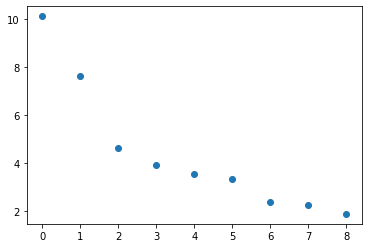

In [58]:
plt.plot(S, 'o')

In [59]:
variance = ((S[0]**2)+(S[1]**2)+(S[2]**2))/np.sum(S**2)
variance

0.7745744342325

We get the same result from sklearn.

In [60]:
# Training dataset
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_tilde)
var = pca.explained_variance_ratio_
var

array([0.43600841, 0.24780262, 0.0907634 ])

In [61]:
variance = np.sum(var)
variance

0.7745744342324987

In [62]:
X_new_pca = pca.transform(X_train_tilde)
X_new_pca.shape

(720, 3)

In [63]:
# MSE for training dataset
regr = linear_model.LinearRegression()
regr.fit(X_new_pca, y_train)

X_new_pca = sm.add_constant(X_new_pca) 

print('Intercept:', regr.intercept_)
print('Coefficients:', regr.coef_)

model = sm.OLS(y_train, X_new_pca).fit()
predictions = model.predict(X_new_pca) 

mse = mean_squared_error(y_train,predictions) 
print(" ")
print("mse:", mse)

Intercept: [0.81270778]
Coefficients: [[-0.24337969 -0.12571635 -0.06881173]]
 
mse: 0.005012844773190191


In [64]:
# Testing dataset
scaler = MinMaxScaler()
X_test_pre_function = scaler.fit_transform(X_test_pre)

In [65]:
mu = np.mean(X_test_pre_function,axis = 0, keepdims = True)
X_test_tilde = X_test_pre_function - mu
X_test_tilde.shape

(100, 9)

In [66]:
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test_tilde)
var = pca.explained_variance_ratio_
var

array([0.4532577 , 0.21668987, 0.11745473])

In [67]:
variance = np.sum(var)
variance

0.7874022968362441

As expected, a similar amount of variance is explained by the first three principal components for the testing dataset.

In [68]:
X_new_pca_test = pca.transform(X_test_tilde)
X_new_pca_test.shape

(100, 3)

In [69]:
# MSE for testing dataset
regr = linear_model.LinearRegression()
regr.fit(X_new_pca_test, y_test)

X_new_pca_test = sm.add_constant(X_new_pca_test) 

print('Intercept:', regr.intercept_)
print('Coefficients:', regr.coef_)

model = sm.OLS(y_test, X_new_pca_test).fit()
predictions = model.predict(X_new_pca_test) 

mse = mean_squared_error(y_test,predictions) 
print(" ")
print("mse:", mse)

Intercept: [0.81287126]
Coefficients: [[-0.23395304 -0.11639042 -0.12375661]]
 
mse: 0.0030208995343846638


Our MSE is similar when create our model and MSE algorithm by hand and when we use the built-in sklearn MSE function. This indicates that using our multivariate linear model with PCA might be the ideal model for predicting a new country's social support based on our dataset.